In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, LeakyReLU, ReLU, Input
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:

print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)
print("NumPy version:", np.__version__)



TensorFlow version: 2.17.1
Keras version: 3.5.0
NumPy version: 1.26.4


In [3]:

# Check if GPU is detected
gpu_devices = tf.config.list_physical_devices('GPU')
if gpu_devices:
    print(f"GPU detected: {gpu_devices}")
else:
    print("No GPU detected.")


GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


# Data Loading

In [4]:
# Define dataset paths
monet_path = "/kaggle/input/gan-getting-started/monet_jpg"
photo_path = "/kaggle/input/gan-getting-started/photo_jpg"

# Function to load and decode images
def load_jpeg_images(path):
    image_files = tf.io.gfile.glob(path + "/*.jpg")  # Get all image paths
    dataset = tf.data.Dataset.from_tensor_slices(image_files)

    # Function to load and decode an image
    def load_and_preprocess_image(image_path):
        image = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image, channels=3)  # Decode JPEG (RGB)
        image = tf.image.convert_image_dtype(image, tf.float32)  # Normalize [0,1]
        return image

    dataset = dataset.map(load_and_preprocess_image)  # Apply function
    return dataset

# Load datasets
monet_ds = load_jpeg_images(monet_path)
photo_ds = load_jpeg_images(photo_path)

# Print a sample image shape
for img in monet_ds.take(1):
    print("Image shape:", img.shape)


Image shape: (256, 256, 3)


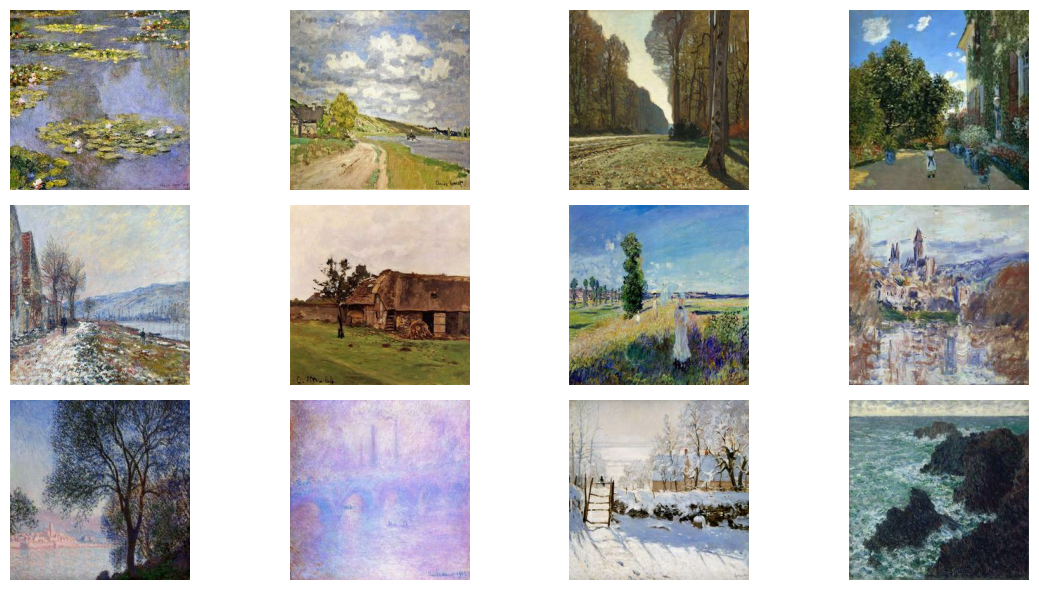

In [5]:
# Plot the first 12 images
plt.figure(figsize=(12, 6))
for i, img in enumerate(monet_ds.take(12)):
    plt.subplot(3, 4, i + 1)  # 3 rows, 4 columns
    plt.imshow(img.numpy())  # Convert tensor to numpy array
    plt.axis("off")

plt.tight_layout()
plt.show()

# EDA

## Data Overview

In [6]:

# Count number of images in each dataset
num_monet = len(os.listdir(monet_path))
num_photos = len(os.listdir(photo_path))

print(f"Number of Monet paintings: {num_monet}")
print(f"Number of real photos: {num_photos}")


Number of Monet paintings: 300
Number of real photos: 7038


In [7]:

# Load a single image to check its shape
sample_monet = next(iter(monet_ds.take(1))).numpy()
sample_photo = next(iter(photo_ds.take(1))).numpy()

print(f"Monet Image Shape: {sample_monet.shape}")
print(f"Photo Image Shape: {sample_photo.shape}")

Monet Image Shape: (256, 256, 3)
Photo Image Shape: (256, 256, 3)


##  Histogram of RGB Values in Monet's Paintings

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


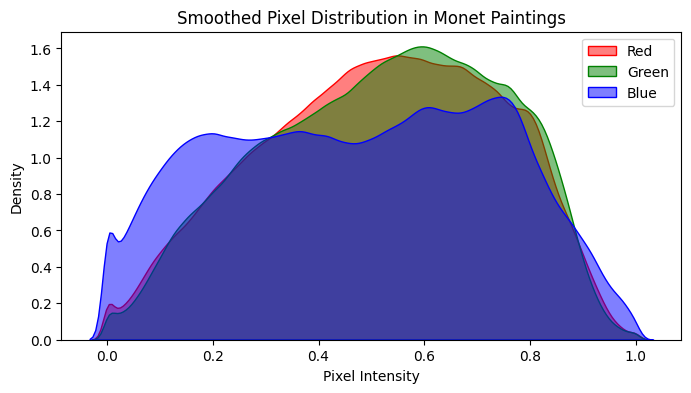

In [8]:

def plot_smooth_pixel_distribution(dataset, title):
    all_pixels_r, all_pixels_g, all_pixels_b = [], [], []

    for img in dataset.take(100):  # Sample 100 images
        img = img.numpy()
        all_pixels_r.extend(img[:, :, 0].flatten())  # Red channel
        all_pixels_g.extend(img[:, :, 1].flatten())  # Green channel
        all_pixels_b.extend(img[:, :, 2].flatten())  # Blue channel

    # Convert lists to Pandas Series (automatically handles NaN)
    df_r = pd.Series(all_pixels_r)
    df_g = pd.Series(all_pixels_g)
    df_b = pd.Series(all_pixels_b)

    # Remove Inf values (Seaborn doesn't like them)
    df_r.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_g.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_b.replace([np.inf, -np.inf], np.nan, inplace=True)

    plt.figure(figsize=(8, 4))
    
    # Smooth using KDE (Kernel Density Estimation)
    sns.kdeplot(df_r.dropna(), color='red', label="Red", fill=True, alpha=0.5)
    sns.kdeplot(df_g.dropna(), color='green', label="Green", fill=True, alpha=0.5)
    sns.kdeplot(df_b.dropna(), color='blue', label="Blue", fill=True, alpha=0.5)
    
    plt.title(title)
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

# Plot smoothed pixel distributions for Monet paintings
plot_smooth_pixel_distribution(monet_ds, "Smoothed Pixel Distribution in Monet Paintings")


* Blue dominates over Red & Green: Monet paintings use cooler tones, especially blues.
* Peaks in Green and Red at mid-intensity (~0.6): Suggests warm highlights exist in some areas (like sunsets or trees).
* More uniform distribution across colors


## Brightness

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


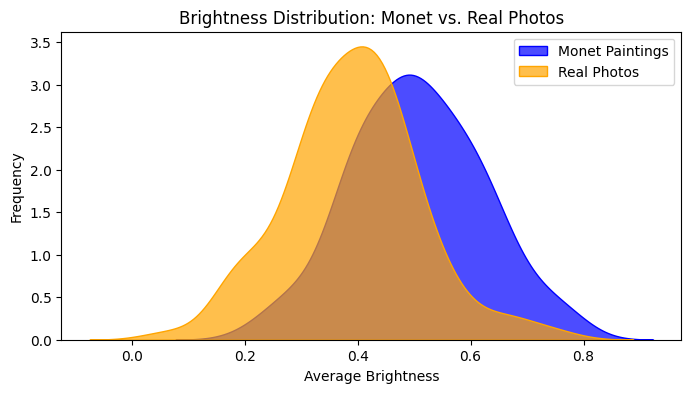

In [9]:
def compute_brightness(img):
    return np.mean(img.numpy())  # Compute mean pixel value (brightness)

monet_brightness = [compute_brightness(img) for img in monet_ds.take(100)]
photo_brightness = [compute_brightness(img) for img in photo_ds.take(100)]

# Plot brightness comparison
plt.figure(figsize=(8, 4))
sns.kdeplot(monet_brightness,alpha=0.7,fill=True, label="Monet Paintings", color='blue')
sns.kdeplot(photo_brightness,alpha=0.7,fill=True, label="Real Photos", color='orange')
plt.xlabel("Average Brightness")
plt.ylabel("Frequency")
plt.legend()
plt.title("Brightness Distribution: Monet vs. Real Photos")
plt.show()


* The Monet brightness curve is more concentrated, meaning Monet paintings have similar, consistent brightness levels.
* The real photo curve is wider, meaning real-world images have more variation in lighting conditions.

In [10]:
def compute_mean_rgb(dataset):
    mean_r, mean_g, mean_b = [], [], []

    for img in dataset.take(100):
        img = img.numpy()
        mean_r.append(np.mean(img[:, :, 0]))  # Red channel
        mean_g.append(np.mean(img[:, :, 1]))  # Green channel
        mean_b.append(np.mean(img[:, :, 2]))  # Blue channel

    return np.mean(mean_r), np.mean(mean_g), np.mean(mean_b)

# Compute mean RGB values
monet_mean_rgb = compute_mean_rgb(monet_ds)
photo_mean_rgb = compute_mean_rgb(photo_ds)

print(f"Mean RGB in Monet Paintings: {monet_mean_rgb}")
print(f"Mean RGB in Real Photos: {photo_mean_rgb}")


Mean RGB in Monet Paintings: (0.51579034, 0.522129, 0.47601232)
Mean RGB in Real Photos: (0.40299296, 0.40478015, 0.36389068)


- All three RGB values are higher in Monet paintings, meaning Monet's artwork is overall brighter than real photos.

#### 🔍 Summary of Findings

| **Metric**            | **Monet Paintings**                 | **Real Photos**                | **What It Means**                                |
|----------------------|----------------------------------|------------------------------|------------------------------------------------|
| **Pixel Density Plot** | Blue appears more frequently    | More balanced                | Monet uses soft, cool tones                   |
| **Mean RGB Values**  | R & G are slightly higher       | All values lower             | Monet’s highlights raise overall warmth       |
| **Contrast**         | Less contrast, blended colors   | More contrast                | Real photos capture sharp light variations    |


# GAN Training

## Normalize data 

In [80]:

# Define dataset paths
monet_path = "/kaggle/input/gan-getting-started/monet_jpg"
photo_path = "/kaggle/input/gan-getting-started/photo_jpg"

# Function to load and preprocess images
def load_and_preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)  # Decode JPEG
    image = tf.image.resize(image, [256, 256])  # Resize to 256x256
    image = (tf.cast(image, tf.float32) / 127.5) - 1  # Normalize to [-1,1]
    return image

# Load datasets
monet_ds = tf.data.Dataset.list_files(monet_path + "/*.jpg").map(load_and_preprocess_image).batch(1)
photo_ds = tf.data.Dataset.list_files(photo_path + "/*.jpg").map(load_and_preprocess_image).batch(1)


In [81]:
from tensorflow.keras.layers import Layer

class InstanceNormalization(Layer):
    def __init__(self, epsilon=1e-5):
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon

    def build(self, input_shape):
        self.gamma = self.add_weight(shape=(input_shape[-1],), initializer="ones", trainable=True)
        self.beta = self.add_weight(shape=(input_shape[-1],), initializer="zeros", trainable=True)

    def call(self, inputs):
        mean, var = tf.nn.moments(inputs, axes=[1, 2], keepdims=True)
        return self.gamma * (inputs - mean) / tf.sqrt(var + self.epsilon) + self.beta


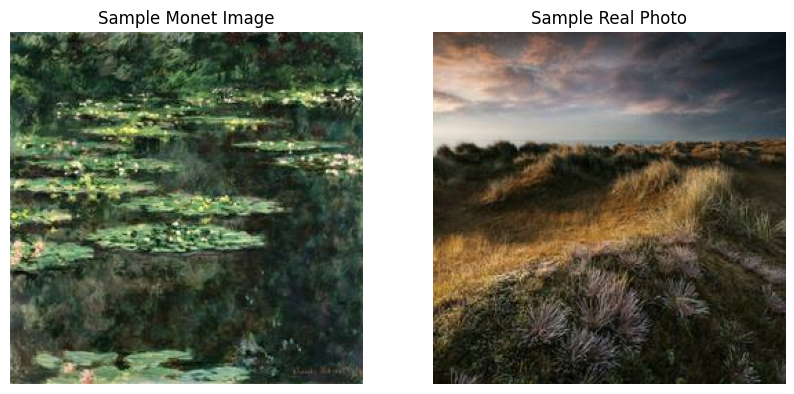

In [82]:
import matplotlib.pyplot as plt

# Get a batch of images
sample_monet = next(iter(monet_ds))
sample_photo = next(iter(photo_ds))

# Display
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow((sample_monet.numpy()[0] + 1) / 2)  # Convert [-1,1] to [0,1]
ax[0].set_title("Sample Monet Image")
ax[0].axis("off")

ax[1].imshow((sample_photo.numpy()[0] + 1) / 2)  # Convert [-1,1] to [0,1]
ax[1].set_title("Sample Real Photo")
ax[1].axis("off")

plt.show()


## Define the CycleGAN Model

In [83]:
from tensorflow.keras import layers, Model

def residual_block(x):
    """Residual block for CycleGAN generator."""
    res = layers.Conv2D(256, (3, 3), padding='same', activation=None)(x)
    res = InstanceNormalization()(res)
    res = layers.ReLU()(res)
    
    res = layers.Conv2D(256, (3, 3), padding='same', activation=None)(res)
    res = InstanceNormalization()(res)
    
    return layers.Add()([x, res])  # Skip connection

def build_generator():
    inputs = layers.Input(shape=(256, 256, 3))

    # Initial Convolution
    x = layers.Conv2D(64, (7, 7), padding='same', activation=None)(inputs)
    x = InstanceNormalization()(x)
    x = layers.ReLU()(x)

    # Downsampling
    x = layers.Conv2D(128, (3, 3), strides=2, padding='same', activation=None)(x)
    x = InstanceNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(256, (3, 3), strides=2, padding='same', activation=None)(x)
    x = InstanceNormalization()(x)
    x = layers.ReLU()(x)

    # Residual Blocks (CycleGAN uses 6 for 256x256 images)
    for _ in range(6):
        x = residual_block(x)

    # Upsampling
    x = layers.Conv2DTranspose(128, (3, 3), strides=2, padding='same', activation=None)(x)
    x = InstanceNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same', activation=None)(x)
    x = InstanceNormalization()(x)
    x = layers.ReLU()(x)

    # Output layer with tanh activation (CycleGAN output should be in [-1,1])
    x = layers.Conv2D(3, (7, 7), padding='same', activation='tanh')(x)

    return Model(inputs, x)



In [84]:
from tensorflow.keras import layers, Model

def build_discriminator():
    inputs = layers.Input(shape=(256, 256, 3))

    # Convolutional layers (PatchGAN Discriminator)
    x = layers.Conv2D(64, (4, 4), strides=2, padding='same')(inputs)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Conv2D(128, (4, 4), strides=2, padding='same')(x)
    x = InstanceNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Conv2D(256, (4, 4), strides=2, padding='same')(x)
    x = InstanceNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Conv2D(512, (4, 4), strides=1, padding='same')(x)  # One more layer for more depth
    x = InstanceNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    # Output layer - PatchGAN uses a feature map instead of a single value
    x = layers.Conv2D(1, (4, 4), padding='same')(x)  # Output feature map (NOT a single value)

    return Model(inputs, x)





In [85]:
# Step 1: Create models FIRST
G = build_generator()  # Photo → Monet
F = build_generator()  # Monet → Photo
D_M = build_discriminator()  # Monet Discriminator
D_P = build_discriminator()  # Photo Discriminator

# Step 2: Force TensorFlow to initialize model variables
sample_input = tf.random.normal([1, 256, 256, 3])  # Dummy input

_ = G(sample_input, training=False)  # Run forward pass to initialize
_ = F(sample_input, training=False)
_ = D_M(sample_input, training=False)
_ = D_P(sample_input, training=False)



In [60]:
print("Available optimizers:", dir(tf.keras.optimizers))


Available optimizers: ['Adadelta', 'Adafactor', 'Adagrad', 'Adam', 'AdamW', 'Adamax', 'Ftrl', 'Lamb', 'Lion', 'LossScaleOptimizer', 'Nadam', 'Optimizer', 'RMSprop', 'SGD', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'deserialize', 'get', 'legacy', 'schedules', 'serialize']


In [86]:
# Step 3: Define optimizers
generator_optimizer = tf.keras.optimizers.RMSprop(learning_rate=2e-4)
discriminator_optimizer = tf.keras.optimizers.RMSprop(learning_rate=2e-4)


In [87]:
# Step 4: Define Loss Functions
# Define Loss Functions BEFORE train_step()
bce_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def adversarial_loss(real, fake):
    real_loss = bce_loss(tf.ones_like(real), real)
    fake_loss = bce_loss(tf.zeros_like(fake), fake)
    return real_loss + fake_loss

cycle_loss = tf.keras.losses.MeanAbsoluteError()

## Train the model

In [88]:
def train_step(real_photo, real_monet):
        with tf.GradientTape(persistent=True) as tape:
            # Generate fake Monet and fake Photo
            fake_monet = G(real_photo, training=True)
            fake_photo = F(real_monet, training=True)
    
            # Cycle consistency
            cycled_photo = F(fake_monet, training=True)
            cycled_monet = G(fake_photo, training=True)
    
            # Discriminator outputs
            real_monet_pred = D_M(real_monet, training=True)
            fake_monet_pred = D_M(fake_monet, training=True)
            real_photo_pred = D_P(real_photo, training=True)
            fake_photo_pred = D_P(real_photo, training=True)
    
            # Compute losses
            g_loss = adversarial_loss(real_monet_pred, fake_monet_pred) + cycle_loss(real_photo, cycled_photo)
            f_loss = adversarial_loss(real_photo_pred, fake_photo_pred) + cycle_loss(real_monet, cycled_monet)
            d_monet_loss = adversarial_loss(real_monet_pred, fake_monet_pred)
            d_photo_loss = adversarial_loss(real_photo_pred, fake_photo_pred)
    
            # Compute gradients
            gradients_g = tape.gradient(g_loss, G.trainable_variables)
            gradients_f = tape.gradient(f_loss, F.trainable_variables)
            gradients_d_m = tape.gradient(d_monet_loss, D_M.trainable_variables)
            gradients_d_p = tape.gradient(d_photo_loss, D_P.trainable_variables)
        
            # Apply gradients
            generator_optimizer.apply_gradients(zip(gradients_g, G.trainable_variables))
            generator_optimizer.apply_gradients(zip(gradients_f, F.trainable_variables))
            discriminator_optimizer.apply_gradients(zip(gradients_d_m, D_M.trainable_variables))
            discriminator_optimizer.apply_gradients(zip(gradients_d_p, D_P.trainable_variables))

        return g_loss, f_loss, d_monet_loss, d_photo_loss


In [89]:
EPOCHS = 10  # Increase for better results
batch_size = 1  # CycleGAN usually works with batch size 1
log_interval = 2  # Print updates every 2 epochs


In [93]:
import gc
gc.collect()
tf.keras.backend.clear_session()

In [90]:
import time
from itertools import zip_longest  # Ensures dataset length consistency

# Training loop
for epoch in range(EPOCHS):
    start_time = time.time()

    # Loop over dataset (ensure all images are used)
    for real_photo, real_monet in zip_longest(photo_ds, monet_ds, fillvalue=None):
        if real_photo is None or real_monet is None:
            continue  # Skip if dataset sizes mismatch

        g_loss, f_loss, d_monet_loss, d_photo_loss = train_step(real_photo, real_monet)

    # Print loss values (Convert to numpy after execution)
    if (epoch + 1) % log_interval == 0:
        print(f"Epoch {epoch+1}/{EPOCHS} - "
              f"Generator Loss: {g_loss.numpy():.4f}, "
              f"Discriminator Loss: {d_monet_loss.numpy():.4f}")

    print(f"Epoch {epoch+1} completed in {time.time() - start_time:.2f} seconds.")

print("🎉 Training Complete!")


ResourceExhaustedError: Exception encountered when calling Conv2D.call().

[1m{{function_node __wrapped__Conv2D_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[1,256,64,64] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Conv2D][0m

Arguments received by Conv2D.call():
  • inputs=tf.Tensor(shape=(1, 64, 64, 256), dtype=float32)